In [108]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F

In [109]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [110]:
device = torch.device("cpu")

In [111]:
from torchvision.transforms.transforms import Resize
class CustomDataset(Dataset):
  def __init__(self,folder_img, folder_mask):
    self.path_img = sorted(list(filter(None,[os.path.join(folder_img,i) if "tiff" in i else None for i in os.listdir(folder_img)])))
    self.path_mask = sorted(list(filter(None,[os.path.join(folder_mask,i) if "tiff" in i else None for i in os.listdir(folder_mask)])))

  def transformation(self, path, grayscale = False):
    if not grayscale:
      img = Image.open(path)
    else:
      img = Image.open(path).convert("L")
    transform = transforms.Compose([
        # transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    return transform(img)

  def __getitem__(self, index):
    return self.transformation(self.path_img[index]),self.transformation(self.path_mask[index], grayscale=True) 

  def __len__(self):
    return len(self.path_img)

In [112]:
train_dataset = CustomDataset("/content/gdrive/MyDrive/train","/content/gdrive/MyDrive/train_mask")
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 1, pin_memory = True)

In [119]:
size = 256 # patch size
stride = 256 # patch stride
channels_img = 3
channels_mask = 1
for img, mask in train_dataloader:
  print(mask.size())
  print(torch.unique(mask))
  img = img.unfold(1,channels_img,channels_img).unfold(2, size, stride).unfold(3, size, stride)
  img = img.reshape(img.size(0)*img.size(2)*img.size(3),channels_img,size,size)
  mask = mask.unfold(1,1,1).unfold(2, size, stride).unfold(3, size, stride)
  mask = mask.reshape(mask.size(0)*mask.size(2)*mask.size(3),channels_mask,size,size)
  break

torch.Size([1, 1, 4536, 4704])
tensor([0., 1.])


In [134]:
class PatchedImageLoader(Dataset):
  def __init__(self,patched_tensor_imgs, patched_tensor_masks):
    self.patched_tensor_imgs = patched_tensor_imgs
    self.patched_tensor_masks = patched_tensor_masks

  def __getitem__(self, index):
      return self.patched_tensor_imgs[index], self.patched_tensor_masks[index]

  def __len__(self):
    return self.patched_tensor_imgs.size(0)

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
train_dataset = PatchedImageLoader(img, mask)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)
# model.load_state_dict(torch.load("/content/model_unet.h5",map_location=device))
# model.eval()

# # mask = torch.zeros((17*256,18*256)).to(device)
# count_batch = 0
# for img in train_dataloader:
#   out = model(img.to(device))
#   # torch.save(out,f"/content/gdrive/MyDrive/patches/{count_batch}.pt")
#   torchvision.utils.save_image(out.squeeze(0),f"/content/gdrive/MyDrive/image_patches/{count_batch}.tiff")
#   count_batch+=1

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [136]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)
model.load_state_dict(torch.load("/content/model_unet.h5",map_location=device))
model.eval()

grid = []
for img, mask in train_dataloader:
  grid.append(img)
  grid.append(mask)
  out = model(img.to(device))
  grid.append(out)
  break

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Text(0.5, 1.0, 'Predicted Mask')

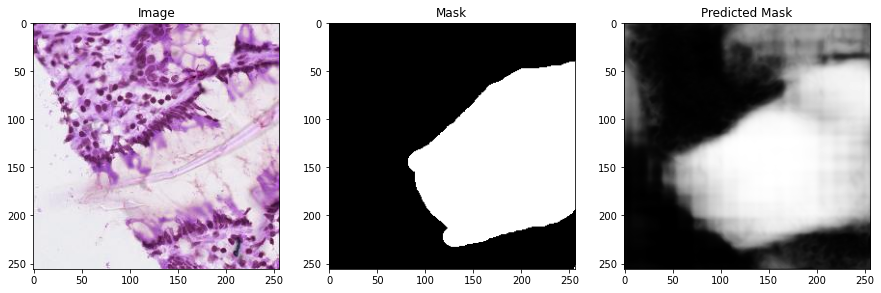

In [143]:
from IPython.core.pylabtools import figsize
f, axarr = plt.subplots(1,3,figsize = (15,15))
axarr[0].imshow(grid[0].squeeze(0).permute(1,2,0))
axarr[0].set_title("Image")
axarr[1].imshow(grid[1].squeeze(0).squeeze(0),cmap = "gray")
axarr[1].set_title("Mask")
axarr[2].imshow(grid[2].squeeze(0).squeeze(0).detach().numpy(),cmap = "gray")
axarr[2].set_title("Predicted Mask")